In [1]:
#Funções de risco e de retorno de carteiras
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns)){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [2]:
options(warn = -1, scipen = 999)
pacotes <- c("dplyr", "tidyr","ggplot2","tidyquant","pracma","rmgarch","rugarch")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [3]:
#Ações escolhidas
acoes <- c("MGLU3.SA","WEGE3.SA","B3SA3.SA","PRIO3.SA","TRPL4.SA","ITSA4.SA")
reta <- tq_get(acoes, from = "2013-01-04") %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = dailyReturn) %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit

In [4]:
#Pegando o ano, mês e dia da primeira observação
year <- lubridate::year(dplyr::first(reta$date))
month <- lubridate::month(dplyr::first(reta$date))
day <- lubridate::day(dplyr::first(reta$date))

In [5]:
#Transformando em série temporal
reta_ts <- ts(reta[,2:ncol(reta)], start = c(year,month,day), frequency = 252)

In [6]:
multspec <- multispec(replicate(length(acoes),
                                ugarchspec()))
multf <- multifit(multispec = multspec, data = reta_ts)
multfor <- multiforecast(multf, n.ahead = 2)
spec1 <- dccspec(uspec = multspec, dccOrder = c(1,1), distribution = "mvnorm")
fit1 <- dccfit(spec1, data = reta_ts, fit = multf, fit.control = list(eval.se = T))
fore <- dccforecast(fit = fit1, n.ahead = 2)

In [7]:
#Matriz de covariância
cov1 <- rcov(fit1)
cov <- cov1[,,dim(cov1)[3]]
cov_f <- rcov(fore)
cov_f <- cov_f[[1]]
cov_f1 <- cov_f[1:length(acoes),1:length(acoes),1]
cov_f2 <- cov_f[1:length(acoes),1:length(acoes),2]

In [8]:
#Desvio das ações
sd <- matrix(0, nrow = length(acoes))
sd_f1 <- matrix(0, nrow = length(acoes))
sd_f2 <- matrix(0, nrow = length(acoes))
for(i in 1:nrow(sd)){
  sd[[i]] <- dplyr::last(multf@fit[[i]]@fit[["sigma"]])
  sd_f1[[i]] <- multfor@forecast[[i]]@forecast[["sigmaFor"]][1]
  sd_f2[[i]] <- multfor@forecast[[i]]@forecast[["sigmaFor"]][2]
}
rownames(sd) <- sort(acoes)
rownames(sd_f1) <- sort(acoes)
rownames(sd_f2) <- sort(acoes)
sd_a <- sd*sqrt(252)
sd_a_f1 <- sd_f1*sqrt(252)
sd_a_f2 <- sd_f2*sqrt(252)

In [9]:
#Calculando o retorno esperado
retornos_a <- tq_get(acoes, from = Sys.Date()-365*5) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



In [10]:
#Nº de simulações de carteiras a se fazer
n_sim <- 40000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rexp,0.001)
pesos <- apply(pesos,2,function(x)x/sum(x))

In [11]:
#Escolha se prefere o risco atual ou a previsão de risco para 1 período (sd ou sd_f)
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_f2, cov = cov_f2)*sqrt(252)
retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
end <- Sys.time()
end-start

Time difference of 6.987689 secs

In [21]:
#Sharpe
tx_livre_risco <- 0.02
data <- matrix(0, nrow = 3, ncol = n_sim)
data[1,] <- retornos
data[2,] <- riscos
data[3,] <- (retornos-tx_livre_risco)/riscos
rownames(data) <- c("Retornos", "Riscos","Sharpe")

In [13]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



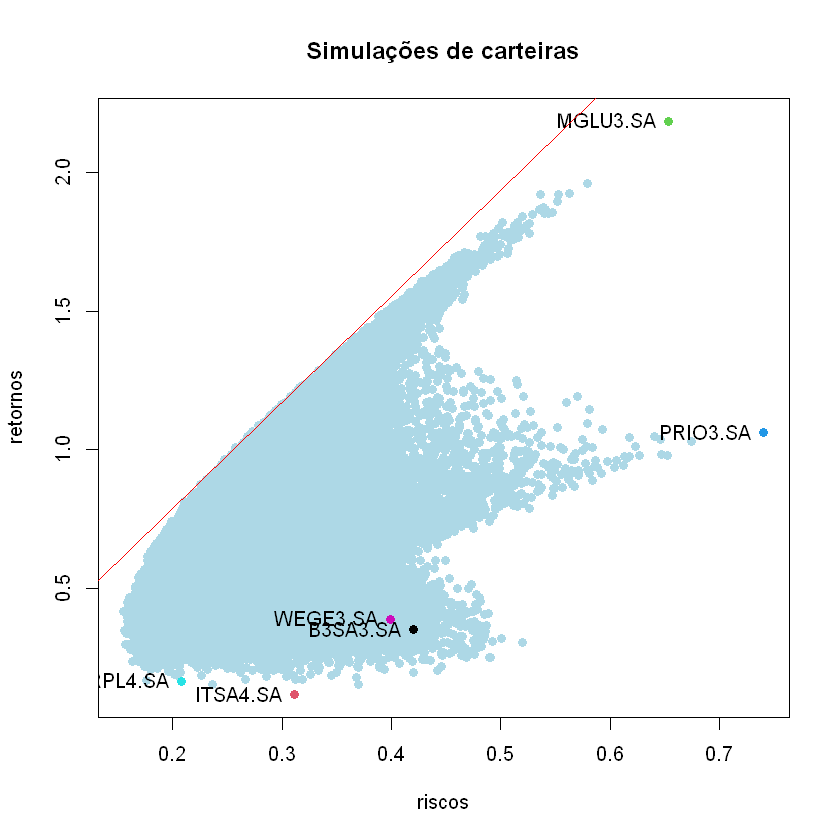

In [15]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_a_f2)),
    ylim = c(min(retorno_med), max(retorno_med)), main = "Simulações de carteiras")
points(x = sd_a_f2, y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_a_f2, y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data[3,]), col = "red")
abline(h = 0,v = 0, lty = 2)

In [16]:
sharpe <- max(data[3,])
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data[1,])
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data[2,])
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     3.835728

Retorno Máximo 
       1.96234

Risco Mínimo 
   0.1554235

In [22]:
#Somente ver a linha que tem o maior sharpe
positivo <- data[3,] == sharpe
show(data[,positivo])

 Retornos    Riscos    Sharpe 
1.0085117 0.2577116 3.8357285 


In [23]:
#Pesos em % da melhor carteira
pesos_efi <- round(pesos[,positivo]*100,2)
names(pesos_efi) <- sort(acoes)
print(pesos_efi)

B3SA3.SA ITSA4.SA MGLU3.SA PRIO3.SA TRPL4.SA WEGE3.SA 
   13.32     0.35    33.12    13.87    27.77    11.57 


In [24]:
#Carteira eficiente com arredondamento de 3 casas decimais
pesos_ef <- round(pesos[,positivo],3)
risco_ef <- portfolio_sd_t(sd = sd_f2, cov = cov_f2, weight = pesos_ef)*sqrt(252)
ret_ef <- portfolio_return(returns = retornos_a[,2:ncol(retornos_a)], weight = pesos_ef)
cart_ef <- data.frame(Risco = risco_ef, Retorno = ret_ef, Sharpe = (ret_ef-tx_livre_risco)/risco_ef)
cart_ef

Risco,Retorno,Sharpe
<dbl>,<dbl>,<dbl>
0.2575611,1.008332,3.837274


In [34]:
p <- c(0.123,0.019,0.346,0.138,0.134,0.24)
portfolio_sd_t(weight = p, cov = cov_f2, sd = sd_f2)*sqrt(252)
portfolio_return(weight = p, returns = retornos_a[,2:ncol(retornos_a)])

[1] 0.2764203

[1] 1.062673